# **Data Visualization**
---

## Objective

- Answer business requirement 1:
    * The client wants to make sure that the animal images are distinguishable from one another and can be used to train a model.

## Inputs

- The folder `inputs/datasets/pets` containing the subfolders `train`, `test`, and `validation`
- The correctly labelled folders in each of these subfolders
- An adequate amount of preprocessed png images (size 128x128) in each labelled folder, showing a snapshot of a pet coming up to a bowl

## Outputs

- Image shape pickle file
- Mean image for each label
- Histograms showing the differences between the means
- Code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard

---
## Preparation
### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
from PIL import Image
import random

sns.set_style("white")


### Set the correct working directory

In [2]:
# Check the current working directory
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [4]:
# Move up to the project top directory
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

### Set the main paths and constant variables

It was decided that the input shape of the images that the model will be trained on shall be (128, 128, 3).

In [69]:
dataset_name = "pets"
full_dataset_path = os.path.normpath(os.path.join(cwd, 'inputs/datasets', dataset_name))
output_path = os.path.join(cwd, 'outputs')
train_path = os.path.join(full_dataset_path, 'train')
test_path = os.path.join(full_dataset_path, 'test')
validation_path = os.path.join(full_dataset_path, 'validation')

INPUT_SHAPE = (-1, 128, 128, 3)
joblib.dump(INPUT_SHAPE, f'{output_path}/input_shape.pkl')
LABELS = sorted(joblib.load(f'{output_path}/class_dict.pkl').values())

# The following line should show a list containing the subsets of the split dataset
os.listdir(full_dataset_path)

['test', 'train', 'validation']

### Create style for highlighting errors and warnings

In [7]:
from colorama import Fore, Style

# Error notification style
def print_err(message):
    print(f'{Fore.RED}ERROR:{Style.RESET_ALL}\n{message}')

# Warning notification style
def print_warn(message):
    print(f'{Fore.YELLOW}WARNING:{Style.RESET_ALL}\n{message}')

### Util function to display a progress bar

In [99]:
def show_progress(label, list_len, counter):
    width = 100
    if list_len == counter:
        print(f'\r{label:<10}: {"#"*list_len:<{width}}|| ', end='')
    print(f'\r{label:<10}: {"#"*int(counter//(list_len/width)):<{width}}|| ', end='')

---
## Step 1
### Show image montage

Let's take a look at our dataset to make sure it is useable.

In [88]:
import itertools

def show_montage(nrows, ncols, labels):
    
    list_rows = range(0, nrows)
    list_cols = range(0, ncols)
    plot_idx = list(itertools.product(list_rows, list_cols))

    for label in labels:
        label_path = os.path.join(train_path, label)
        label_files = os.listdir(label_path)
        rnd_sample = random.sample(label_files, nrows*ncols)
        montage_sample = np.array([], dtype='float32')

        for img in rnd_sample:
            image = Image.open(os.path.join(label_path, img))
            image = np.asarray(image)/255.0
            montage_sample = np.append(montage_sample, image.flatten())

        montage_sample = montage_sample.reshape(INPUT_SHAPE)
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
        for idx, img in enumerate(rnd_sample):
            axes[plot_idx[idx][0]][plot_idx[idx][1]].imshow(montage_sample[idx], cmap='gray')
            axes[plot_idx[idx][0]][plot_idx[idx][1]].axis('off')

        plt.suptitle(t=f'{label.upper()}:', fontsize='x-large')
        plt.axis('off')
        plt.tight_layout()
        plt.show()


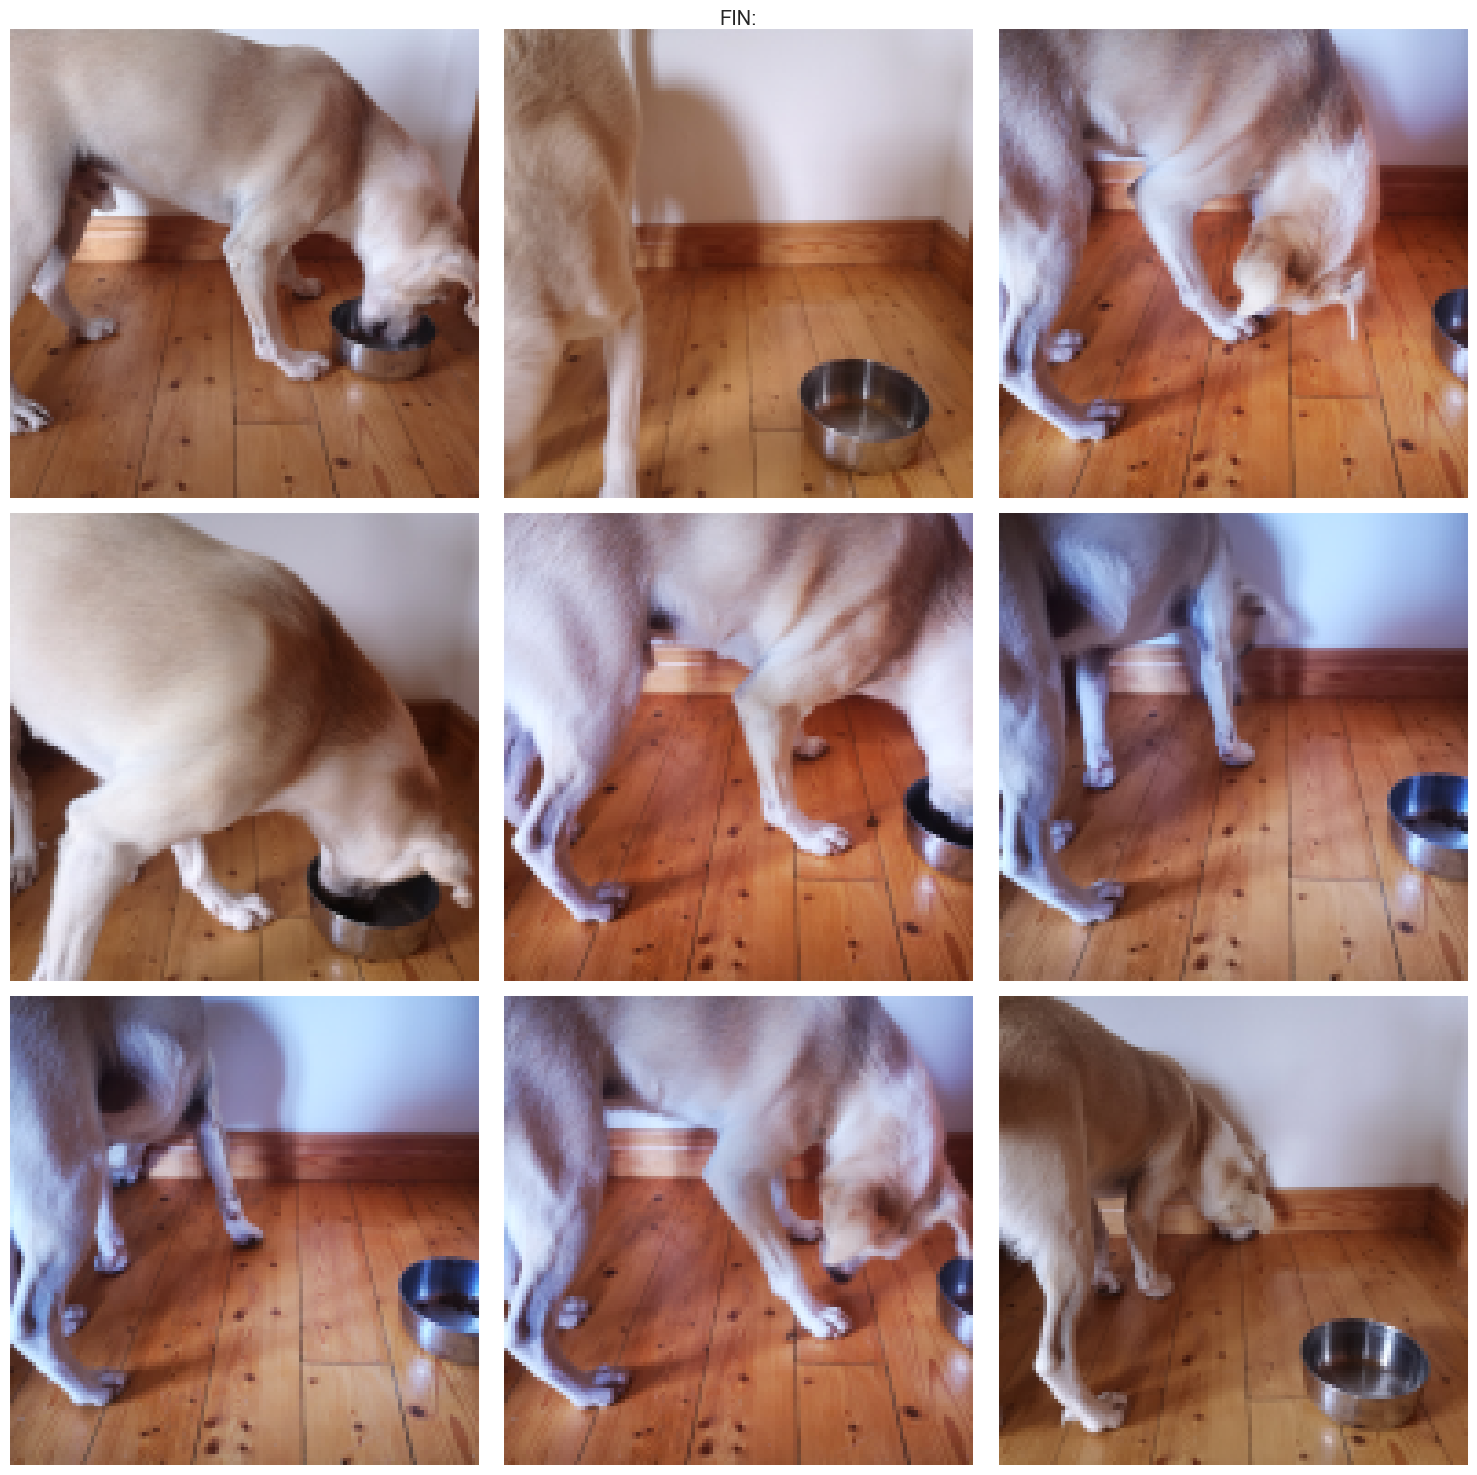

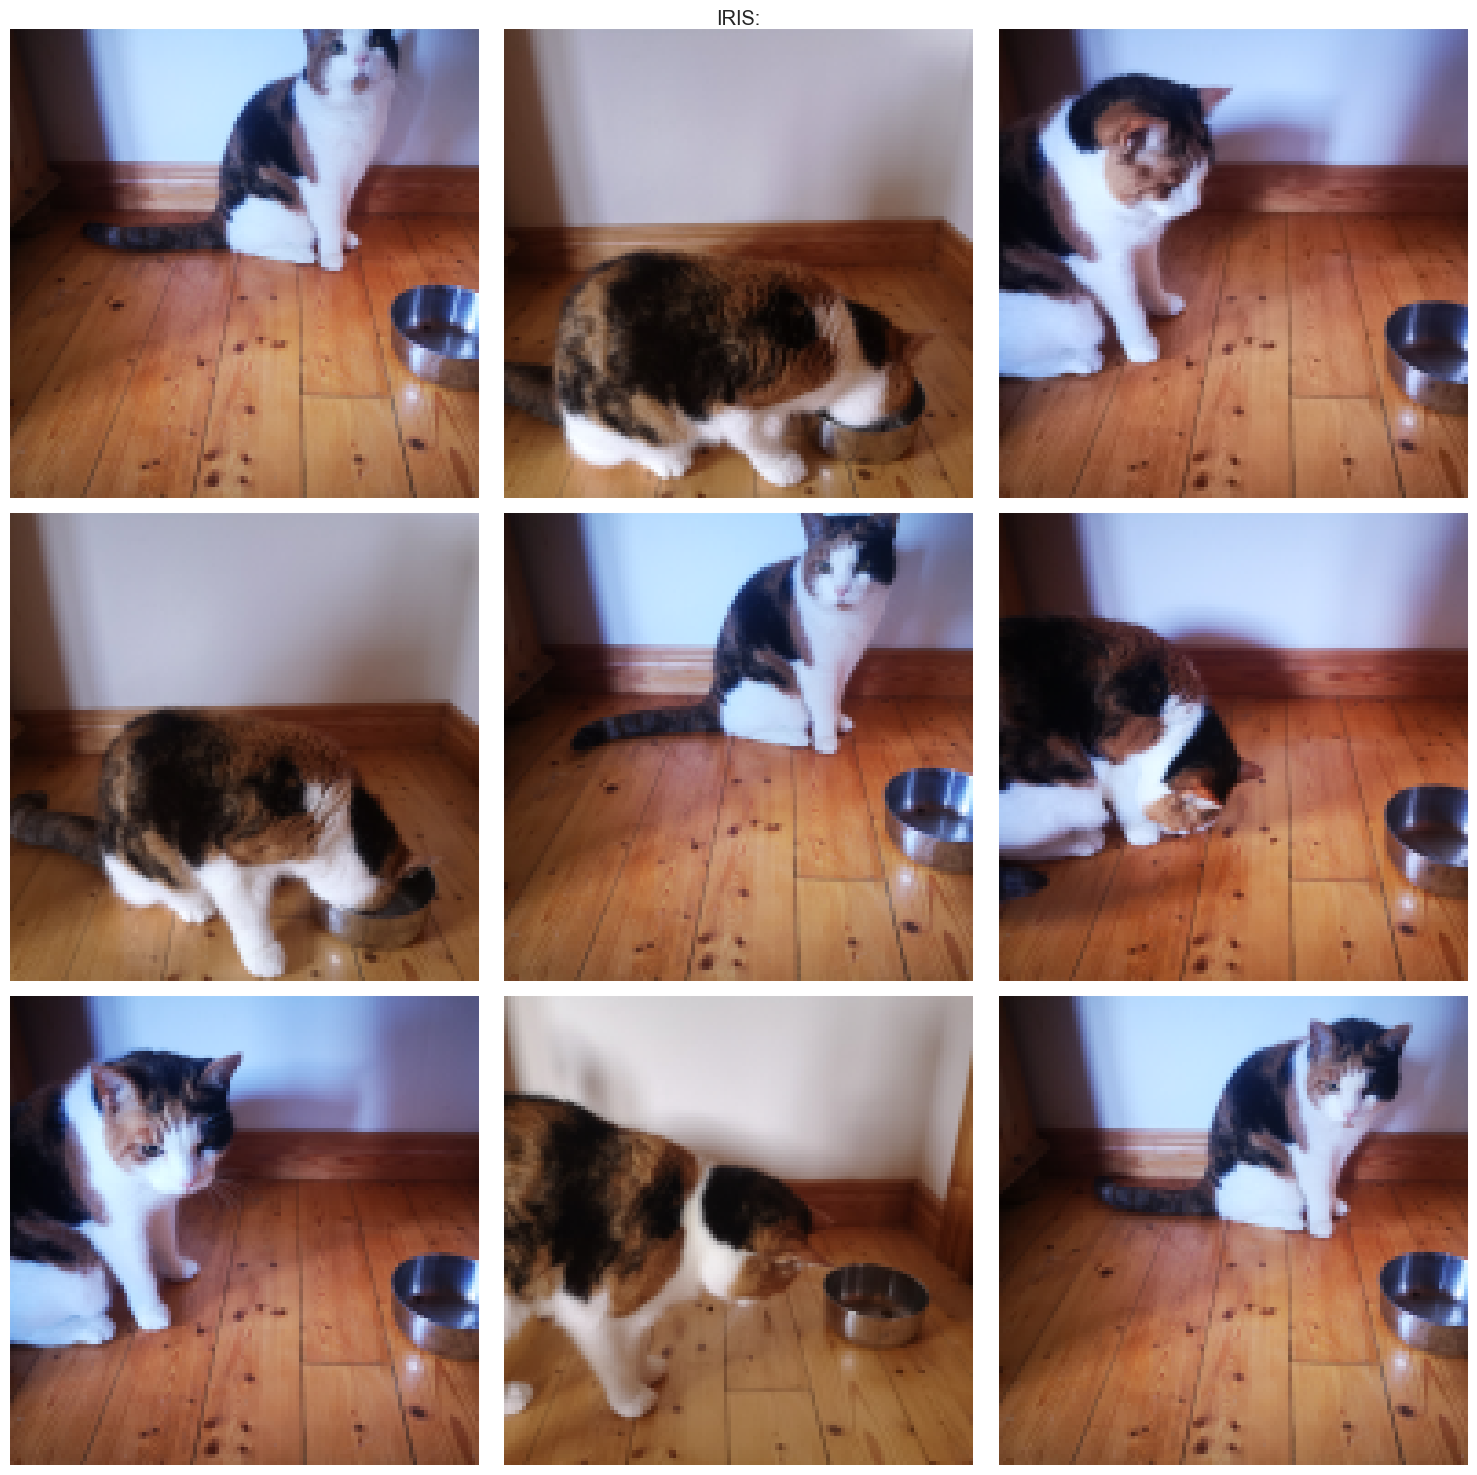

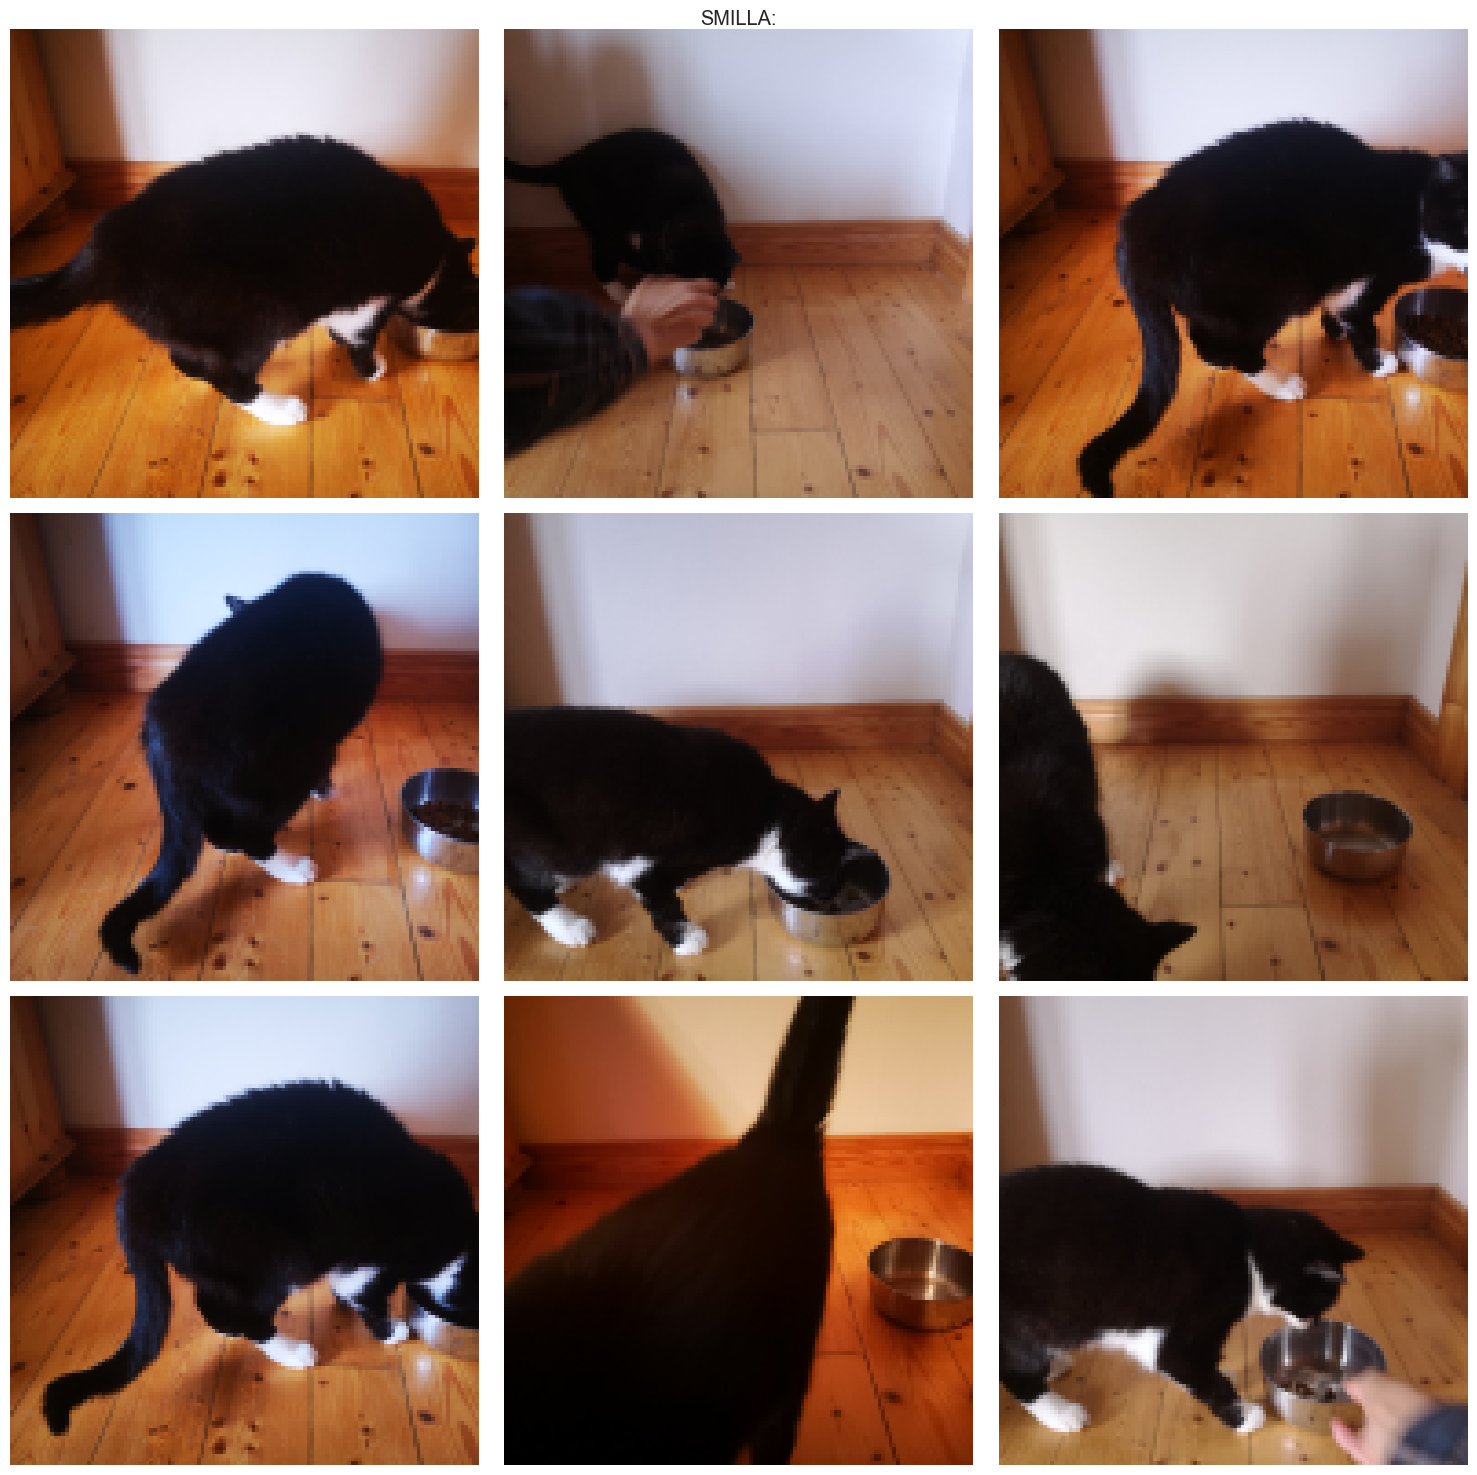

In [89]:
show_montage(3, 3, LABELS)

## Step 2
### Load image sample for visualization

Function to load all images into an array

In [104]:
# Load images from specified folder, resize them, save them as np array in X and save their labels in y
def save_images_in_array(path, shape, amount):
    
    dims = tuple(shape[1:3])
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    print(f'Loading from {path}:')
    
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        img_list = random.sample(os.listdir(label_path), min(amount, len(os.listdir(label_path))))
        counter = 0

        for img_name in img_list:
            img = image.load_img(os.path.join(path, label, img_name))
            if img.size != dims:
                img = img.resize(dims, resample=Image.LANCZOS)
            img_resized = image.img_to_array(img)
            if img_resized.max() > 1:
                img_resized = img_resized / 255.0
            X = np.append(X, img_resized).reshape(shape)
            y = np.append(y, label)
            counter += 1
            show_progress(label, len(img_list), counter)

        print(f'{counter} images loaded')

    # Shuffle the training set
    train_set = list(zip(y, X))
    random.shuffle(train_set)
    y_shuffled, X_shuffled = list(map(list, zip(*train_set)))
    X = np.array(X_shuffled, dtype='float32')
    y = np.array(y_shuffled, dtype='object')
    
    return X, y

            

In [105]:
# Load a sample of training images into an array
X_sample, y_sample = save_images_in_array(train_path, INPUT_SHAPE, amount=50)

Loading from d:\Projekte\Coding\CodeInstitute\PP5\inputs\datasets\pets\train:
fin       : ####################################################################################################|| 50 images loaded
iris      : ####################################################################################################|| 50 images loaded
smilla    : ####################################################################################################|| 50 images loaded


## Step 3
### Show average images for each label

In [ ]:

import itertools
import functools


def show_averages(X, y, labels):
    
    label_imgs = {'Means': {}, 'Vars': {}}
    #labels = np.unique(y)
    print(labels)
    
#    sm_mean = np.mean(X['smilla'])
    
    old = False
    
    for label in labels:

        y = y.reshape(-1, 1, 1)
        bool_mask = np.any(y == label, axis=1).reshape(-1)
        arr = X[bool_mask]
        
       # arr = arr[:, 40:120, 20:100, :]
        
        f10 = arr[20:50]
        n10 = arr[60:90]
        mean1 = np.mean(f10, axis=0)
        mean2 = np.mean(n10, axis=0)
        
       

        plt.imshow(mean1, cmap='gray')
        plt.show()
        plt.imshow(mean2, cmap='gray')
        plt.show()
        plt.imshow(abs(mean1 - mean2))
        plt.show()
        print('diff between means of same animal')
        print(np.mean(mean1 - mean2))
        print('std between same animal')
        print(np.std(mean1 - mean2))
        print(np.std(f10))
        print(np.std(n10))
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(131)
        _, _, patches = ax1.hist(mean1.flatten(), bins=100, color='b')
        y_lim_1 = np.array([i.get_height() for i in patches]).max()
        
        ax2 = fig.add_subplot(132)
        #ax2.hist(mean2.flatten(), bins=100)
        _, _, patches = ax2.hist(mean2.flatten(), bins=100, color='b')
        y_lim_2 = np.array([i.get_height() for i in patches]).max()
        
        ax3 = fig.add_subplot(133)
        #ax3.hist(abs(mean1 - mean2).flatten(), bins=100)
        data = abs(mean1 - mean2).flatten()
        y_val, bin_edges, _ = ax3.hist(data, bins=np.arange(min(data), max(data) + 0.01, 0.01))
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        ax3.plot(bin_centers, y_val, '-', c='black')

        #y_lim_3 = np.array([i.get_height() for i in patches]).max()

        y_lim = max(y_lim_1, y_lim_2)
        print(y_lim)
        ax1.set(xlim=(0,1), ylim=(0, y_lim))
        ax2.set(xlim=(0,1), ylim=(0, y_lim))
        ax3.set(xlim=(0,1))#, ylim=(0, y_lim))
        
        plt.show()

#         plt.hist(mean2.flatten(), bins=100)
# #        plt.set(xlim=(0,1))
#         plt.show()
#         plt.hist(abs(mean1 - mean2).flatten(), bins=100)
# #        plt.set(xlim=(0,1))
#         plt.show()
        #hist = np.histogram
        
       # sns.histplot((mean2[...].reshape(-1), mean1[...].reshape(-1)), bins=50)
       # plt.show()
       # sns.histplot(mean2[...].reshape(-1)- mean1[...].reshape(-1), bins=50)
       # plt.show()

        
        print(type(old))
        if str(type(old)) != "<class 'bool'>":
            plt.imshow(abs(old - mean2))
            plt.show()
            print('diff between means of two animals')
            print(np.mean(old - mean2))
            print('std between two animals')
            print(np.std(old - mean2))
            print(np.std(old))
            print(np.std(mean2))
            
            # sns.histplot(old[...,0].reshape(-1), bins=50)
            # plt.show()
            # sns.histplot(mean2[...,0].reshape(-1), bins=50)
            # plt.show()
            fig = plt.figure(figsize=(15, 5))
            ax1 = fig.add_subplot(131)
            n, bins, patches = ax1.hist(old.flatten(), bins=100)
            y_lim_1 = np.array([i.get_height() for i in patches]).max()
            
            ax2 = fig.add_subplot(132)
            #ax2.hist(mean2.flatten(), bins=100)
            n, bins, patches = ax2.hist(mean2.flatten(), bins=100)
            y_lim_2 = np.array([i.get_height() for i in patches]).max()
            
            ax3 = fig.add_subplot(133)
            #ax3.hist(abs(old - mean2).flatten(), bins=100)
            data = abs(old - mean2).flatten()
            n, bins, patches = ax3.hist(data, bins=np.arange(min(data), max(data) + 0.01, 0.01))
          #  y_lim_3 = np.array([i.get_height() for i in patches]).max()

            y_lim = max(y_lim_1, y_lim_2)
            print(y_lim)
            ax1.set(xlim=(0,1), ylim=(0, y_lim))
            ax2.set(xlim=(0,1), ylim=(0, y_lim))
            ax3.set(xlim=(0,1))#, ylim=(0, y_lim))
            plt.show()
            
            old = mean2
        else:
            #y = y.reshape(-1, 1, 1)
           # print(y)
            bool_mask = np.any(y == 'smilla', axis=1).reshape(-1)
           # print(bool_mask)

            arr_2 = X[bool_mask]
           # print(arr_2)
          #  arr_2 = arr_2[:, 40:120, 20:100, :]
            old = np.mean(arr_2[:30], axis=0)
            plt.imshow(abs(old - mean2))
            plt.show()
            print('diff between means of two animals, smilla')
            print(np.mean(old - mean2))
            print('std between two animals')
            print(np.std(old - mean2))
            print(np.std(old))
            print(np.std(mean2))
            # sns.histplot(old[...,0].reshape(-1), bins=50)
            # plt.show()
            # sns.histplot(mean2[...,0].reshape(-1), bins=50)
            # plt.show()
            
            fig = plt.figure(figsize=(15, 5))
            ax1 = fig.add_subplot(131)
            n, bins, patches = ax1.hist(old.flatten(), bins=100)
            y_lim_1 = np.array([i.get_height() for i in patches]).max()
            
            ax2 = fig.add_subplot(132)
            #ax2.hist(mean2.flatten(), bins=100)
            n, bins, patches = ax2.hist(mean2.flatten(), bins=100)
            y_lim_2 = np.array([i.get_height() for i in patches]).max()
            
            ax3 = fig.add_subplot(133)
            #ax3.hist(abs(old - mean2).flatten(), bins=100)
            data = abs(old - mean2).flatten()
            n, bins, patches = ax3.hist(data, bins=np.arange(min(data), max(data) + 0.01, 0.01))
            #y_lim_3 = np.array([i.get_height() for i in patches]).max()

            y_lim = max(y_lim_1, y_lim_2)
            print(y_lim)
            ax1.set(xlim=(0,1), ylim=(0, y_lim))
            ax2.set(xlim=(0,1), ylim=(0, y_lim))
            ax3.set(xlim=(0,1))#, ylim=(0, y_lim))
            plt.show()
            
            old = mean1
                

        # plt.imshow(np.std(arr[:30], axis=0))
        # plt.show()
        # plt.imshow(np.mean(arr[:30], axis=0))
        # plt.show()


        X_mean = np.mean(arr, axis=0)
        label_imgs['Means'][label] = X_mean
        
        label_imgs['Vars'][label] = {}
        for channel in [0, 1, 2]:
            X_dev = np.std(arr[..., channel], axis=0)
            label_imgs['Vars'][label][channel] = X_dev
        X_dev_all = np.std(arr, axis=0)
        label_imgs['Vars'][label][4] = X_dev_all

    means = label_imgs['Means']
    vars = label_imgs['Vars']
    fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(len(labels)*5, 5))
    for idx, label in enumerate(labels):
        axes[idx].set_title(f"Average image for label {label}")
        axes[idx].imshow(means[label], cmap='gray')

    # for ch in [0, 1, 2]:
    #     for idx, label in enumerate(labels):
    #         axes[ch+1][idx].set_title(f"Channel {ch} variation image for label {label}")
    #         axes[ch+1][idx].imshow(vars[label][ch], cmap='gray')
            
    # for idx, label in enumerate(labels):
    #     axes[4][idx].set_title(f"All channel variation image for label {label}")
    #     axes[4][idx].imshow(vars[label][4], cmap='gray')
        
    
    # TODO: save figure
    plt.tight_layout()
    plt.show()

    # len(labels) should be the amount of combos
    combos_len = sum(1 for _ in itertools.combinations(labels, 2))
    nrows = max(1, combos_len // 3)
    ncols = combos_len + (combos_len % 3)
    x_size = ncols * 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(x_size, nrows*5))
    for idx, combo in enumerate(itertools.combinations(labels, 2)):
        # mc = (means[combo[0]] - means[combo[1]]).reshape(-1)
        # mc = np.array([c if c > 0 else 0 for c in mc]).astype('float').reshape(200, 200, 3)
        #print(mc)
        mc = abs(means[combo[0]] - means[combo[1]])
        print('diff between all means of two animals')
        print(np.mean(means[combo[0]] - means[combo[1]]))
        print('std between means of all animals')
        print(np.std(means[combo[0]] - means[combo[1]]))
        
        axes[idx].set_title(f"Difference between {combo[0]} and {combo[1]}:")
        axes[idx].imshow(mc, cmap='gray')
        
        #print(f'Difference between {combo[0]} and {combo[1]}:')
        #plt.imshow(mc)
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt. subplots(nrows=nrows, ncols=ncols, figsize=(x_size, nrows*5))
    for idx, combo in enumerate(itertools.combinations(labels, 2)):
        print(combo)
        params = axes[idx].hist(abs(means[combo[0]] - means[combo[1]]).flatten(), bins=np.arange(0, 1, 0.02))
        bin_centers = 0.5 * (params[1][1:] + params[1][:-1])
        axes[idx].plot(bin_centers, params[0], '-', c='black')
#    plt.hist((means[combo[0]] - means[combo[1]]).flatten(), bins=100)
    plt.show()
    
    # fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(x_size, nrows*5))
    # for idx, combo in enumerate(itertools.combinations(labels, 2)):
    #     print(combo)
    #     new_arr = np.array([abs(means[combo[0]][...,0] - means[combo[1]][...,0]).flatten(), 
    #                         abs(means[combo[0]][...,1] - means[combo[1]][...,1]).flatten(), 
    #                         abs(means[combo[0]][...,2] - means[combo[1]][...,2]).flatten()]).reshape(-1, 3)
    #     axes[idx].set_title(f"Difference in means between {combo[0]} and {combo[1]}:")
    #     # params = axes[idx].hist((means[combo[0]][...,0] - means[combo[1]][...,0]).flatten(), bins=50, alpha=1, color='r')
    #     # y_lim = np.array([i.get_height() for i in params[2]]).max()
    #     # params = axes[idx].hist((means[combo[0]][...,1] - means[combo[1]][...,1]).flatten(), bins=50, alpha=0.7, color='g')
    #     # y_lim = max(np.array([i.get_height() for i in params[2]]).max(), y_lim)
    #     # params = axes[idx].hist((means[combo[0]][...,2] - means[combo[1]][...,2]).flatten(), bins=50, alpha=0.4, color='b')
    #     # y_lim = max(np.array([i.get_height() for i in params[2]]).max(), y_lim)
    #     #params = axes[idx].hist(new_arr[0], bins=np.arange(0, 1, 0.02), alpha=1, color=['red', 'green', 'blue'])
    #     axes[idx].hist(new_arr[..., 0], bins=np.arange(0, 1, 0.02), alpha=0.5, color='red')
    #     axes[idx].hist(new_arr[..., 1], bins=np.arange(0, 1, 0.02), alpha=0.5, color='green')
    #     y_val, bin_edges, p = axes[idx].hist(new_arr[..., 2], bins=np.arange(0, 1, 0.02), alpha=0.5, color='blue')
    #     bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    #     axes[idx].plot(bin_centers, y_val, '-', c='black')
        
        
    fig, axes = plt. subplots(nrows=nrows, ncols=ncols, figsize=(x_size, nrows*5))
    for idx, combo in enumerate(itertools.combinations(labels, 2)):
        print(combo)
        axes[idx].set_title(f"Difference in means between {combo[0]} and {combo[1]}:")
        params = axes[idx].hist((means[combo[0]][...,0] - means[combo[1]][...,0]).flatten(), bins=100, alpha=0.5, color='r')
        y_lim = np.array([i.get_height() for i in params[2]]).max()
        params = axes[idx].hist((means[combo[0]][...,1] - means[combo[1]][...,1]).flatten(), bins=100, alpha=0.5, color='g')
        y_lim = max(np.array([i.get_height() for i in params[2]]).max(), y_lim)
        params = axes[idx].hist((means[combo[0]][...,2] - means[combo[1]][...,2]).flatten(), bins=100, alpha=0.5, color='b')
        y_lim = max(np.array([i.get_height() for i in params[2]]).max(), y_lim)
        axes[idx].set(ylim=(0, y_lim), xlim=(0,1))
        # bin_centers = 0.5 * (params[1][1:] + params[1][:-1])
        # axes[idx].plot(bin_centers, params[0], '-', c='black')
        
    plt.show()
    
        #print(params[0].max())
       # y_lim = max([i.get_height() for i in params[2][0]])
       # axes[idx].set(xlim=(0,1), ylim=(0,y_lim))

#    plt.hist((means[combo[0]] - means[combo[1]]).flatten(), bins=100)
    
    plt.show()

    if len(labels) > 2:
        diffs = np.clip(abs(functools.reduce(lambda a, b: a - b, means.values())), 0, 1)
        plt.suptitle(f'Difference between all labels:')
        plt.imshow(diffs)
        plt.show()
        
    
    # plt.imshow(means['smilla'] - vars['smilla'][4])
    # plt.show()
    
    # plt.imshow(means['iris'] - vars['iris'][4])
    # plt.show()
    
    # plt.imshow(means['fin'] - vars['fin'][4])
    # plt.show()

#X_train_new = joblib.load(f'{output_path}/extra/X_train.pkl')
#y_ohe_train_new = joblib.load(f'{output_path}/extra/y_ohe_train.pkl')
#y_train_new = np.array(pd.from_dummies(y_ohe_train_new))

show_averages(X_sample, y_sample, LABELS)
# show_averages(X_train, y_train, 'iris')
# show_averages(X_train, y_train, 'smilla')


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
# axes[0].set_title(f"Average image for label {label_to_display}")
# axes[0].imshow(avg_img, cmap='gray')


The resulting images show clearly that each label is distinguishable from the others.

### Save new image shape

In [ ]:
img_set_shape = X_sample.shape
print(img_set_shape)
joblib.dump(value=img_set_shape, filename=f"{output_path}/img_set_shape_extra.pkl")